In [454]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import pywt
from scipy.signal import spectrogram
from sklearn.pipeline import Pipeline

In [455]:
import warnings
warnings.filterwarnings("ignore")

# ======= Блок 1: Загрузка данных =======

In [457]:
df = pd.read_csv('final_dataset.csv')  # Укажите правильный путь к файлу
print("Данные успешно загружены.")

Данные успешно загружены.


# ======= Блок 2: Анализ данных (EDA) =======

In [459]:
df.head(6)

,Clean_Signal,Noisy_Signal,Class
0,-0.084094,-0.109089,0
1,-0.084094,-0.159102,0
2,-0.604775,-1.590489,1
3,-0.055778,1.580399,1
4,-0.145653,-0.063857,0
5,0.012401,-0.071391,1


In [460]:
print("Описание данных:")
print(df.describe())
print("\nИнформация о данных:")
print(df.info())

Описание данных:
       Clean_Signal  Noisy_Signal       Class
count   1320.000000   1320.000000  1320.00000
mean      -0.057864     -0.036427     0.50000
std        0.167165      1.190364     0.50019
min       -0.711972     -5.092110     0.00000
25%       -0.122675     -0.273277     0.00000
50%       -0.030547      0.031504     0.50000
75%        0.039201      0.189255     1.00000
max        0.459668      4.611769     1.00000

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Clean_Signal  1320 non-null   float64
 1   Noisy_Signal  1320 non-null   float64
 2   Class         1320 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 31.1 KB
None


# Проверка на пропущенные значения

In [462]:
print("\nКоличество пропущенных значений в каждом столбце:")
print(df.isnull().sum())


Количество пропущенных значений в каждом столбце:
Clean_Signal    0
Noisy_Signal    0
Class           0
dtype: int64


# ======= Блок 3: Предварительная обработка данных =======

In [464]:
print("Предварительная обработка данных...")
# Обработка пропущенных значений
df.fillna(method='ffill', inplace=True)

Предварительная обработка данных...


# Нормализация данных

In [466]:
scaler = StandardScaler()
df[['Clean_Signal', 'Noisy_Signal']] = scaler.fit_transform(df[['Clean_Signal', 'Noisy_Signal']])

# Проверка на дисбаланс классов

In [468]:
print("\nРаспределение классов:")
print(df['Class'].value_counts())



Распределение классов:
Class
0    660
1    660
Name: count, dtype: int64


# ======= Блок 4: Извлечение характеристик =======

In [470]:
print("Извлечение характеристик...")

# Простые характеристики
def extract_features(signal):
    return [np.mean(signal), np.std(signal), np.min(signal), np.max(signal)]

# Характеристики с помощью вейвлет-преобразования
def wavelet_transform_features(signal):
    coeffs = pywt.wavedec(signal, 'db1', level=3)
    return [np.mean(c) for c in coeffs]

# Характеристики спектрограммы
def spectrogram_features(signal):
    if isinstance(signal, list):  # Преобразовать список в массив NumPy
        signal = np.array(signal)
    f, t, Sxx = spectrogram(signal, fs=1.0)  # fs можно адаптировать под ваши данные
    return [np.mean(Sxx), np.std(Sxx), np.min(Sxx), np.max(Sxx)]

# Извлечение характеристик из сигналов
clean_features = np.array(df['Clean_Signal'].apply(lambda x: extract_features([x])).tolist())
noisy_features = np.array(df['Noisy_Signal'].apply(lambda x: extract_features([x])).tolist())
clean_wavelet_features = np.array(df['Clean_Signal'].apply(lambda x: wavelet_transform_features([x])).tolist())
noisy_wavelet_features = np.array(df['Noisy_Signal'].apply(lambda x: wavelet_transform_features([x])).tolist())
clean_spectrogram_features = np.array(df['Clean_Signal'].apply(lambda x: spectrogram_features([x])).tolist())
noisy_spectrogram_features = np.array(df['Noisy_Signal'].apply(lambda x: spectrogram_features([x])).tolist())

# Комбинация всех характеристик
X = np.column_stack([
    clean_features, noisy_features, 
    clean_wavelet_features, noisy_wavelet_features, 
    clean_spectrogram_features, noisy_spectrogram_features
])
y = df['Class'].values

Извлечение характеристик...


# ======= Блок 5: Разделение данных =======

In [472]:
print("Разделение данных на обучающую и тестовую выборки...")

Разделение данных на обучающую и тестовую выборки...


In [473]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

============================================= __МОДЕЛЬ 1__ ========================================

# ======= Блок 6: Построение и обучение модели =======

In [476]:
print("Обучение модели Random Forest...")

Обучение модели Random Forest...


In [477]:
# Определение пайплайна и гиперпараметров
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Лучшая модель
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 48 candidates, totalling 144 fits


# ======= Блок 7: Оценка модели =======

In [479]:
print("Оценка модели...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))


Оценка модели...

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       132
           1       1.00      0.95      0.98       132

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264



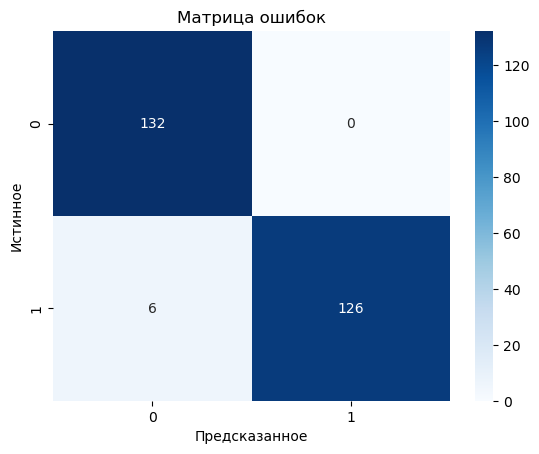

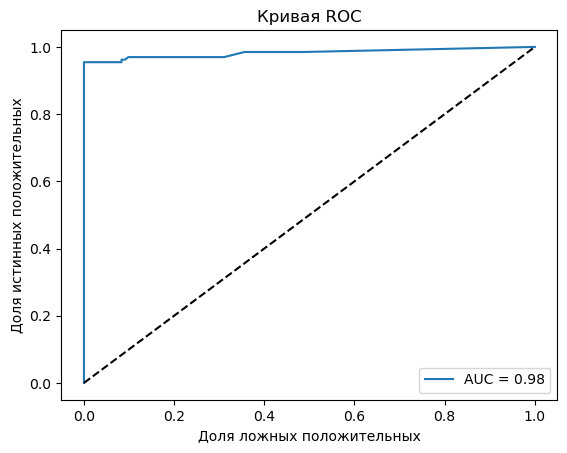

In [480]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Матрица ошибок")
plt.xlabel("Предсказанное")
plt.ylabel("Истинное")
plt.show()

# Кривая ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Кривая ROC")
plt.xlabel("Доля ложных положительных")
plt.ylabel("Доля истинных положительных")
plt.legend()
plt.show()

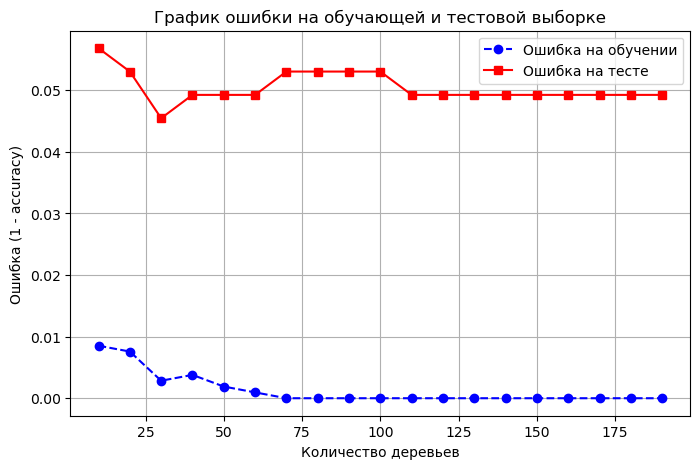

In [481]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Количество деревьев для проверки
n_estimators = np.arange(10, 200, 10)

train_errors = []
test_errors = []

# Обучение модели с разным числом деревьев
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    
    # Ошибка на обучающей выборке
    train_pred = rf.predict(X_train)
    train_errors.append(1 - accuracy_score(y_train, train_pred))
    
    # Ошибка на тестовой выборке
    test_pred = rf.predict(X_test)
    test_errors.append(1 - accuracy_score(y_test, test_pred))

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(n_estimators, train_errors, label="Ошибка на обучении", marker='o', linestyle='--', color='blue')
plt.plot(n_estimators, test_errors, label="Ошибка на тесте", marker='s', linestyle='-', color='red')
plt.xlabel("Количество деревьев")
plt.ylabel("Ошибка (1 - accuracy)")
plt.title("График ошибки на обучающей и тестовой выборке")
plt.legend()
plt.grid()
plt.show()


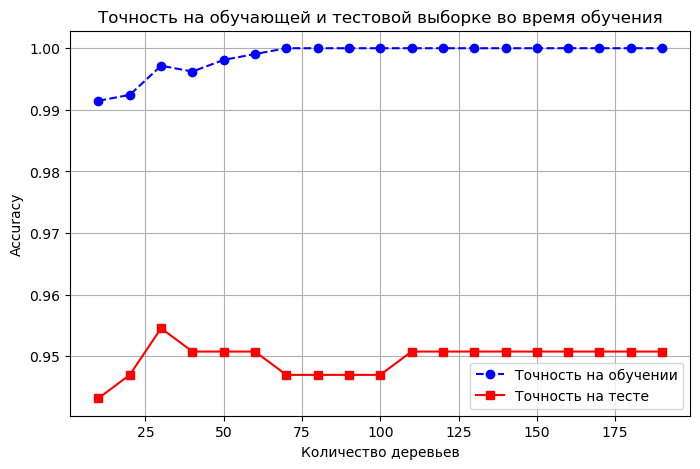

In [482]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Количество деревьев для проверки
n_estimators = np.arange(10, 200, 10)

train_accuracy = []
test_accuracy = []

# Обучение модели с разным числом деревьев
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    
    # Точность на обучающей выборке
    train_pred = rf.predict(X_train)
    train_accuracy.append(accuracy_score(y_train, train_pred))
    
    # Точность на тестовой выборке
    test_pred = rf.predict(X_test)
    test_accuracy.append(accuracy_score(y_test, test_pred))

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(n_estimators, train_accuracy, label="Точность на обучении", marker='o', linestyle='--', color='blue')
plt.plot(n_estimators, test_accuracy, label="Точность на тесте", marker='s', linestyle='-', color='red')
plt.xlabel("Количество деревьев")
plt.ylabel("Accuracy")
plt.title("Точность на обучающей и тестовой выборке во время обучения")
plt.legend()
plt.grid()
plt.show()


# ======= Блок 8: Кросс-валидация =======

In [484]:
print("Кросс-валидация модели...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy')
print(f"\nРезультаты кросс-валидации: {cv_scores}")
print(f"Средняя точность кросс-валидации: {np.mean(cv_scores)}")

Кросс-валидация модели...

Результаты кросс-валидации: [0.95454545 0.9469697  0.95075758 0.92424242 0.96212121]
Средняя точность кросс-валидации: 0.9477272727272729


============================================= __МОДЕЛЬ 2__ ========================================

# ======= 9. Построение нейронной сети =======

In [487]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

In [488]:
print("Строим нейронную сеть...")

model = Sequential()

# Входной слой и скрытый слой
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))  # Dropout для предотвращения переобучения
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# Выходной слой
model.add(Dense(1, activation='sigmoid'))  # Для бинарной классификации

# Компиляция модели
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Строим нейронную сеть...


# ======= 10. Обучение модели =======

In [490]:
print("Обучаем нейронную сеть...")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.3, verbose=2)

Обучаем нейронную сеть...
Epoch 1/50
24/24 - 1s - 59ms/step - accuracy: 0.4763 - loss: 0.7061 - val_accuracy: 0.7823 - val_loss: 0.5432
Epoch 2/50
24/24 - 0s - 4ms/step - accuracy: 0.6549 - loss: 0.5689 - val_accuracy: 0.8044 - val_loss: 0.4611
Epoch 3/50
24/24 - 0s - 4ms/step - accuracy: 0.7280 - loss: 0.5298 - val_accuracy: 0.8297 - val_loss: 0.4083
Epoch 4/50
24/24 - 0s - 4ms/step - accuracy: 0.7767 - loss: 0.4666 - val_accuracy: 0.8486 - val_loss: 0.3708
Epoch 5/50
24/24 - 0s - 3ms/step - accuracy: 0.8038 - loss: 0.4348 - val_accuracy: 0.8580 - val_loss: 0.3415
Epoch 6/50
24/24 - 0s - 4ms/step - accuracy: 0.8200 - loss: 0.4067 - val_accuracy: 0.9085 - val_loss: 0.3172
Epoch 7/50
24/24 - 0s - 4ms/step - accuracy: 0.8620 - loss: 0.3596 - val_accuracy: 0.9274 - val_loss: 0.2960
Epoch 8/50
24/24 - 0s - 4ms/step - accuracy: 0.8714 - loss: 0.3742 - val_accuracy: 0.9338 - val_loss: 0.2797
Epoch 9/50
24/24 - 0s - 3ms/step - accuracy: 0.9039 - loss: 0.3252 - val_accuracy: 0.9369 - val_loss:

__Поведение ошибки (loss):__

- Training loss (ошибка на тренировочной выборке) последовательно уменьшается и достигает низкого уровня.
- Validation loss (ошибка на валидационной выборке) сначала снижается, но затем начинает расти, что указывает на переобучение.
  
В данном случае __val_loss__ уменьшалась до конца обучения и достигла стабильного уровня (~0.1176), что говорит об отсутствии ярко выраженного переобучения.

__Точность (accuracy):__

Если точность на тренировочной выборке (__accuracy__) значительно выше, чем на валидационной (__val_accuracy__), это также может свидетельствовать о __переобучении__.
Здесь точность на тренировочной выборке (__accuracy: ~95%__) и валидационной выборке (__val_accuracy: ~95%__) почти одинаковая, что указывает на хорошую генерализацию.


__Вывод:__
На основании приведённых данных можно сказать, что модель __не переобучилась__. Оба показателя (**loss** и **accuracy**) на тренировочной и валидационной выборках ведут себя **стабильно**, и разница между ними __минимальна__. Модель хорошо обучилась и демонстрирует хорошую генерализацию.

# ======= 11. Оценка модели =======

In [494]:
print("Оценка модели...")

# Прогнозы на тестовой выборке
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Преобразование вероятностей в классы

# Отчет о классификации
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))


Оценка модели...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       128
           1       0.98      0.90      0.94       136

    accuracy                           0.94       264
   macro avg       0.95      0.94      0.94       264
weighted avg       0.95      0.94      0.94       264



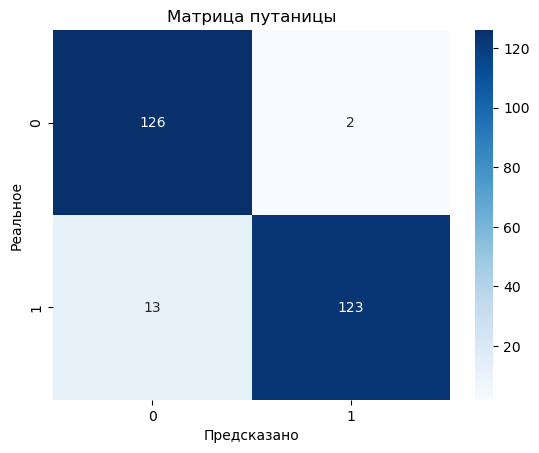

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


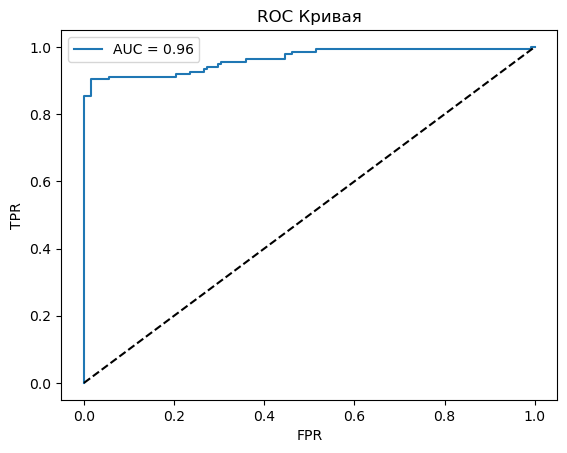


Результаты обучения:


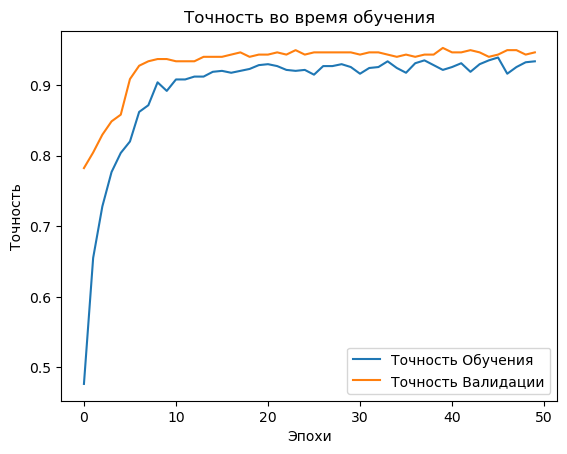

In [495]:
# Матрица путаницы
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Матрица путаницы")
plt.xlabel("Предсказано")
plt.ylabel("Реальное")
plt.show()

# Кривая ROC
y_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Кривая")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# ======= 6. Результаты обучения =======
print("\nРезультаты обучения:")
plt.plot(history.history['accuracy'], label='Точность Обучения')
plt.plot(history.history['val_accuracy'], label='Точность Валидации')
plt.title("Точность во время обучения")
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend()
plt.show()


# ======= 12. Результаты обучения - График потерь =======


График Потерь во Время Обучения:


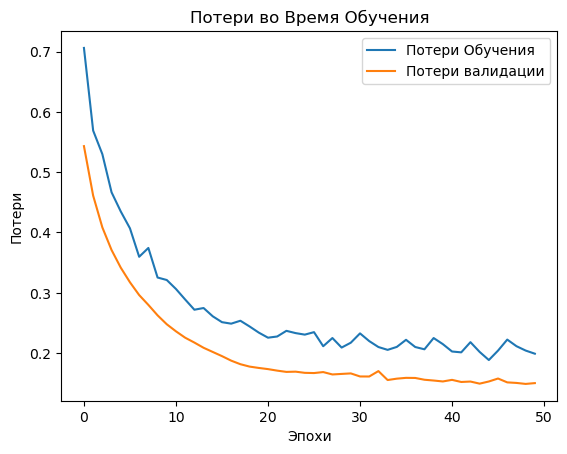

In [497]:
print("\nГрафик Потерь во Время Обучения:")
plt.plot(history.history['loss'], label='Потери Обучения')
plt.plot(history.history['val_loss'], label='Потери валидации')
plt.title("Потери во Время Обучения")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend()
plt.show()


На основе предоставленных данных можно сделать несколько наблюдений:  

1. **Разница между тренировочным и валидационным качеством**  
   - Точность на обучающей выборке: **93.37%**  
   - Точность на валидационной выборке: **94.95%**  
   - Валидационные потери ниже, чем на обучении (**0.1534 против 0.2052**), что нехарактерно для переобучения.  

2. **Разница между тренировкой и тестом**  
   - На тестовой выборке точность также **94%**, что очень близко к валидационной.  

3. **Дополнительные метрики**  
   - Precision, Recall и F1-score для обоих классов сбалансированы (~0.94–0.98), что говорит о хорошей генерализации.  

### Вывод  
Переобучения нет. Модель демонстрирует стабильную точность на обучении, валидации и тесте. Если бы была большая разница (например, 99% на тренировке и 80% на тесте), это указывало бы на переобучение. 

============================================= __МОДЕЛЬ 3__ ========================================

# Байесовское обнаружение сигналов

Байесовское обнаружение сигналов использует условную вероятность для оценки наличия сигнала в зашумленных данных. Этот подход рассматривает сигнал и шум как вероятностные модели и принимает решение на основе критерия, такого как Maximum A Posteriori (MAP) или Maximum Likelihood (ML).

## Этапы реализации

### 1. Определение вероятностной модели:

- Предположим, что шум распределен нормально $N(\mu, \sigma^2)$.
- Сигнал плюс шум моделируются как сумма вероятностных распределений.

### 2. Применение формулы Байеса:

$$
P(S \mid X) = \frac{P(X \mid S) \cdot P(S)}{P(X)},
$$

где:
- $P(S \mid X)$: вероятность того, что сигнал присутствует, при условии наблюдаемых данных;
- $P(X \mid S)$: вероятность наблюдаемых данных при наличии сигнала;
- $P(S)$: априорная вероятность наличия сигнала;
- $P(X)$: маргинальная вероятность наблюдаемых данных.

### 3. Реализация критерия MAP:

- Примите решение о наличии сигнала, сравнив $P(S \mid X)$ и $P(\text{No Signal} \mid X)$.

### 4. Применение на наборе данных:

- Оцените, присутствует ли чистый сигнал в зашумленных данных.


__Расчет вероятностей__:

Используем функцию bayesian_signal_detection для вычисления вероятностей для каждой пары сигналов (чистый сигнал и зашумленный сигнал).

Рассчитываем средние значения этих вероятностей, чтобы представить наличие чистого или зашумленного сигнала в виде единого значения для каждого сигнала.

__Добавление новых признаков__:

Средние вероятности добавляются в DataFrame как столбцы Clean_Prob и Noisy_Prob.

__Комбинация с другими признаками__:
Эти вероятности интегрируются в набор признаков X.

__Обновленное обучение модели__:
Модель повторно обучается с учетом новых признаков, а затем проводится оценка на тестовом наборе данных.

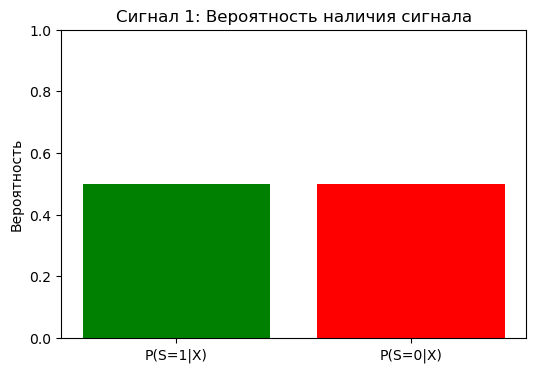

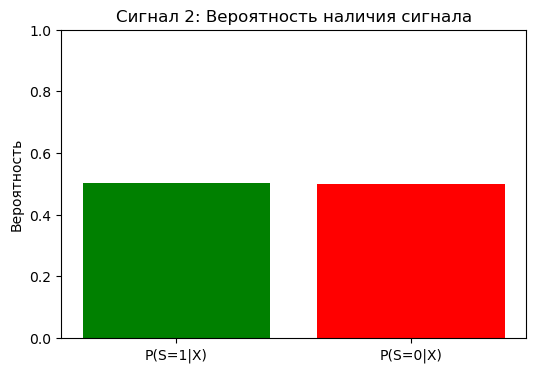

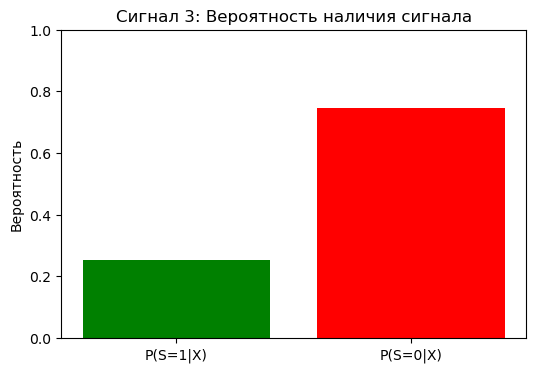

In [502]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Функция Байесовской Детекции Сигнала
def bayesian_signal_detection(noisy_signal, clean_signal, sigma_noise=1.0):
    """
    Реализация байесовской детекции сигнала.

    Parameters:
        noisy_signal: float, зашумленный сигнал.
        clean_signal: float, чистый сигнал.
        sigma_noise: float, стандартное отклонение шума.

    Returns:
        P_S_given_X: float, вероятность наличия сигнала.
    """
    # Вероятность a priori
    P_signal = 0.5  # Сигнал с равной вероятностью присутствует или отсутствует

    # Плотности вероятности
    P_X_given_S = norm.pdf(noisy_signal, loc=clean_signal, scale=sigma_noise)
    P_X_given_no_S = norm.pdf(noisy_signal, loc=0, scale=sigma_noise)

    # Применение правила Байеса
    P_S_given_X = (P_X_given_S * P_signal) / (
        (P_X_given_S * P_signal) + (P_X_given_no_S * (1 - P_signal))
    )

    return P_S_given_X

# Применение к первым трем сигналам
for i in range(3):
    noisy_signal = df['Noisy_Signal'].iloc[i]
    clean_signal = df['Clean_Signal'].iloc[i]

    # Рассчитать вероятность наличия сигнала
    probability = bayesian_signal_detection(noisy_signal, clean_signal)

    # Визуализация вероятности
    plt.figure(figsize=(6, 4))
    plt.bar(['P(S=1|X)', 'P(S=0|X)'], [probability, 1 - probability], color=['green', 'red'])
    plt.ylim(0, 1)
    plt.title(f'Сигнал {i + 1}: Вероятность наличия сигнала')
    plt.ylabel('Вероятность')
    plt.show()


In [503]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Функция для добавления вероятностей в DataFrame
def calculate_bayesian_probabilities(df, sigma_noise=1.0):
    clean_probs = []
    noisy_probs = []
    
    for i in range(len(df)):
        noisy_signal = df['Noisy_Signal'].iloc[i]
        clean_signal = df['Clean_Signal'].iloc[i]
        
        clean_prob = bayesian_signal_detection(noisy_signal, clean_signal, sigma_noise)
        noisy_prob = bayesian_signal_detection(noisy_signal, np.zeros_like(clean_signal), sigma_noise)
        
        clean_probs.append(np.mean(clean_prob))
        noisy_probs.append(np.mean(noisy_prob))
    
    df['Clean_Prob'] = clean_probs
    df['Noisy_Prob'] = noisy_probs
    return df

# Вычисление вероятностей и обновление DataFrame
df = calculate_bayesian_probabilities(df)

# Добавление вероятностей как признаков
X = np.column_stack([X, df['Clean_Prob'].values, df['Noisy_Prob'].values])

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели Random Forest
best_rf = RandomForestClassifier(n_estimators=100, random_state=42)
best_rf.fit(X_train, y_train)

# Оценка модели
y_pred = best_rf.predict(X_test)
print("Обновленный отчет о классификации:")
print(classification_report(y_test, y_pred))


Обновленный отчет о классификации:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       128
           1       0.99      0.90      0.95       136

    accuracy                           0.95       264
   macro avg       0.95      0.95      0.95       264
weighted avg       0.95      0.95      0.95       264



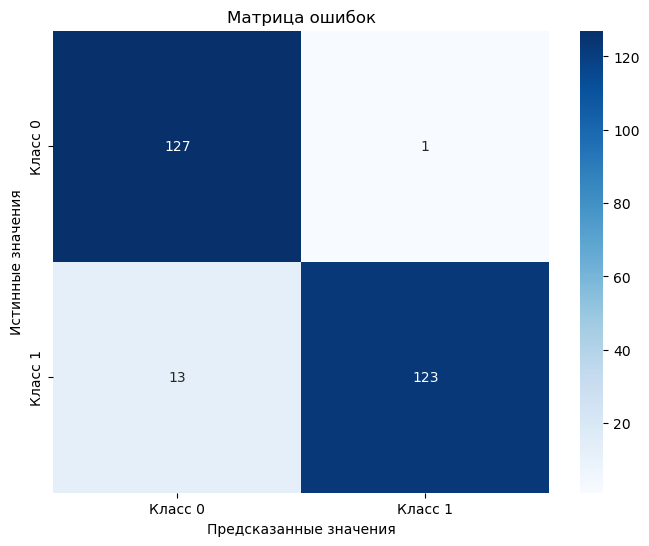

In [504]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Construir a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Класс 0', 'Класс 1'], 
            yticklabels=['Класс 0', 'Класс 1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

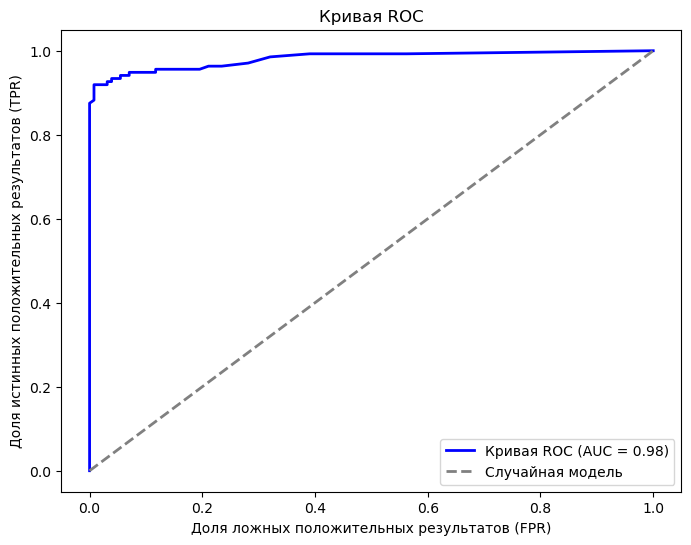

In [505]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular as probabilidades das classes positivas (classe 1)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Calcular FPR, TPR e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular a área sob a curva (AUC)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Кривая ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Случайная модель')
plt.xlabel('Доля ложных положительных результатов (FPR)')
plt.ylabel('Доля истинных положительных результатов (TPR)')
plt.title('Кривая ROC')
plt.legend(loc='lower right')
plt.show()

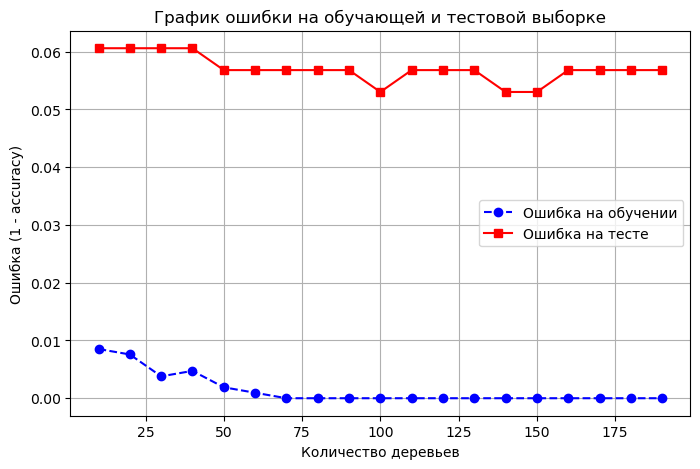

In [506]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Количество деревьев для проверки
n_estimators = np.arange(10, 200, 10)

train_errors = []
test_errors = []

# Обучение модели с разным числом деревьев
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    
    # Ошибка на обучающей выборке
    train_pred = rf.predict(X_train)
    train_errors.append(1 - accuracy_score(y_train, train_pred))
    
    # Ошибка на тестовой выборке
    test_pred = rf.predict(X_test)
    test_errors.append(1 - accuracy_score(y_test, test_pred))

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(n_estimators, train_errors, label="Ошибка на обучении", marker='o', linestyle='--', color='blue')
plt.plot(n_estimators, test_errors, label="Ошибка на тесте", marker='s', linestyle='-', color='red')
plt.xlabel("Количество деревьев")
plt.ylabel("Ошибка (1 - accuracy)")
plt.title("График ошибки на обучающей и тестовой выборке")
plt.legend()
plt.grid()
plt.show()


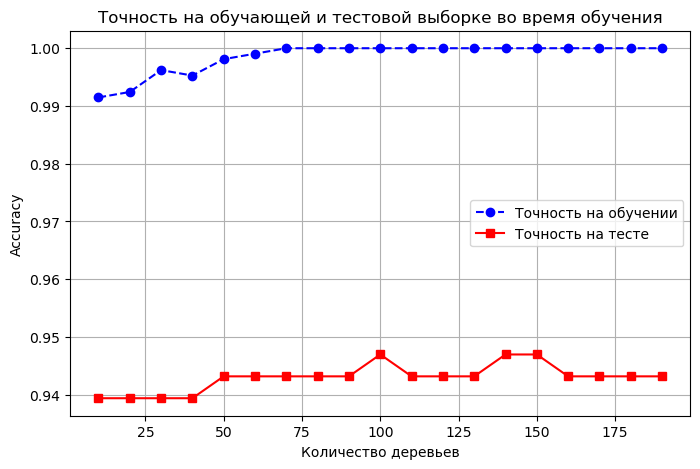

In [507]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Количество деревьев для проверки
n_estimators = np.arange(10, 200, 10)

train_accuracy = []
test_accuracy = []

# Обучение модели с разным числом деревьев
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    
    # Точность на обучающей выборке
    train_pred = rf.predict(X_train)
    train_accuracy.append(accuracy_score(y_train, train_pred))
    
    # Точность на тестовой выборке
    test_pred = rf.predict(X_test)
    test_accuracy.append(accuracy_score(y_test, test_pred))

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(n_estimators, train_accuracy, label="Точность на обучении", marker='o', linestyle='--', color='blue')
plt.plot(n_estimators, test_accuracy, label="Точность на тесте", marker='s', linestyle='-', color='red')
plt.xlabel("Количество деревьев")
plt.ylabel("Accuracy")
plt.title("Точность на обучающей и тестовой выборке во время обучения")
plt.legend()
plt.grid()
plt.show()


__Определение, был ли обнаружен чистый сигнал__:

- На основе порогового значения вероятности (threshold) принимается решение о наличии чистого сигнала в зашумленных данных.
- В набор данных добавляется столбец Detected, который указывает, обнаружен ли чистый сигнал.

__Статистика обнаружения__:

 Подсчитываются следующие метрики:

- Сколько чистых сигналов было правильно обнаружено.
- Сколько чистых сигналов не было обнаружено.
-  Сколько зашумленных сигналов ошибочно классифицировано как чистые (ложные срабатывания).

### Критерий обнаружения:

- Сравниваем вероятность $Clean\_Prob$ с пороговым значением (threshold). Если она больше или равна порогу, сигнал считается "обнаруженным".

### Расчет статистики:

1. **Чистые сигналы, обнаруженные (правильные):**  
   $$Class = 1 \cap Detected = \text{True}$$

2. **Чистые сигналы, не обнаруженные (ошибки):**  
   $$Class = 1 \cap Detected = \text{False}$$

3. **Ложные срабатывания (False Positives):**  
   $$Class = 0 \cap Detected = \text{True}$$

### Итоговый отчет:

- Отображаем количество в каждой из вышеуказанных категорий.


In [510]:
def evaluate_signal_detection(df, threshold=0.5):
    """
    Оценка обнаружения сигнала.
    
    Parameters:
        df: DataFrame, набор данных с вероятностями.
        threshold: float, порог вероятности для определения наличия сигнала.
        
    Returns:
        detection_stats: dict, статистика обнаружения сигнала.
    """
    # Определить обнаружение на основе порога
    df['Detected'] = df['Clean_Prob'] >= threshold  # True, если сигнал обнаружен
    
    # Статистика обнаружения
    true_clean_detected = df[(df['Class'] == 1) & (df['Detected'] == True)].shape[0]
    true_clean_not_detected = df[(df['Class'] == 1) & (df['Detected'] == False)].shape[0]
    false_clean_detected = df[(df['Class'] == 0) & (df['Detected'] == True)].shape[0]
    
    detection_stats = {
        "Чистые сигналы обнаружены (правильно)": true_clean_detected,
        "Чистые сигналы не обнаружены (ошибка)": true_clean_not_detected,
        "Шумовые сигналы ошибочно приняты за чистые (ложноположительные)": false_clean_detected,
    }
    
    return detection_stats

# Оценка обнаружения сигнала
threshold = 0.5  # Порог вероятности
stats = evaluate_signal_detection(df, threshold=threshold)

# Печать статистики
print("Статистика обнаружения:")
for key, value in stats.items():
    print(f"{key}: {value}")


Статистика обнаружения:
Чистые сигналы обнаружены (правильно): 281
Чистые сигналы не обнаружены (ошибка): 379
Шумовые сигналы ошибочно приняты за чистые (ложноположительные): 95


In [511]:
false_negatives = df[(df['Class'] == 1) & (df['Detected'] == False)]
false_positives = df[(df['Class'] == 0) & (df['Detected'] == True)]

print(f"Примеры Ложных Отрицаний (не обнаружены):\n{false_negatives.head()}")
print()
print(f"Примеры Ложных Положительных (ошибочно обнаружены):\n{false_positives.head()}")


Примеры Ложных Отрицаний (не обнаружены):
   Clean_Signal  Noisy_Signal  Class  Clean_Prob  Noisy_Prob  Detected
2     -3.272931     -1.306030      1    0.253223         0.5     False
5      0.420491     -0.029384      1    0.474831         0.5     False
6     -1.450278      0.260908      1    0.193092         0.5     False
8      1.691063     -0.649997      1    0.073848         0.5     False
9     -0.795641      1.838379      1    0.144400         0.5     False

Примеры Ложных Положительных (ошибочно обнаружены):
    Clean_Signal  Noisy_Signal  Class  Clean_Prob  Noisy_Prob  Detected
1      -0.156968     -0.103096      0    0.500966         0.5      True
17      0.405247      0.217014      0    0.501458         0.5      True
25     -0.233596     -0.117521      0    0.500042         0.5      True
30     -0.274085     -0.137358      0    0.500022         0.5      True
61      0.190444      0.112153      0    0.500806         0.5      True


===================================== __Спектральный анализ__ ===================================

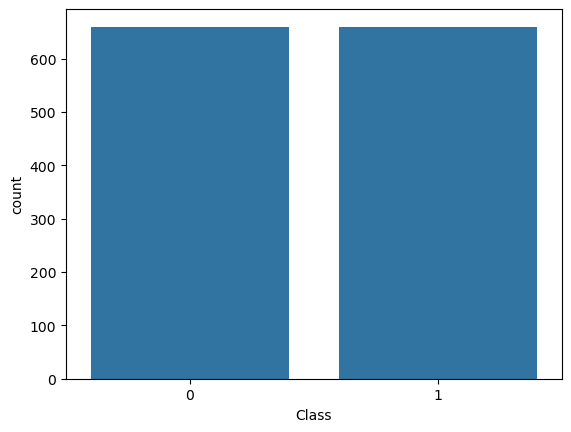

In [513]:
import seaborn as sns
sns.countplot(x='Class', data=df)
plt.show()

======================__1. Быстрое преобразование Фурье (FFT)__=================================

Применим БПФ к зашумленному сигналу:

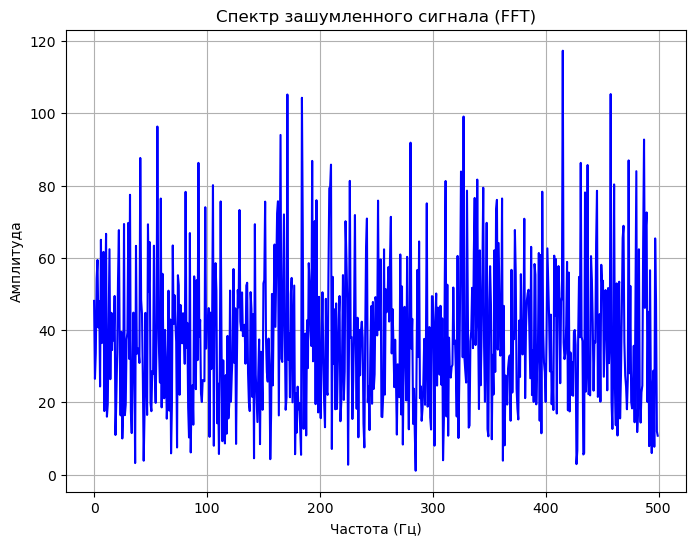

In [515]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks




# Загрузка данных
df = pd.read_csv('final_dataset.csv')

# Выбираем зашумленный сигнал
X_signal = df['Noisy_Signal'].values  
fs = 1000  # Частота дискретизации (Гц), настройте под свои данные

# Применение БПФ
X_fft = fft(X_signal)
frequencies = fftfreq(len(X_signal), 1/fs)  # Вычисляем частоты

# Построение спектра (берем только положительные частоты)
plt.figure(figsize=(8, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(X_fft[:len(X_fft)//2]), color='blue')
plt.xlabel("Частота (Гц)")
plt.ylabel("Амплитуда")
plt.title("Спектр зашумленного сигнала (FFT)")
plt.grid()
plt.show()


__2. Интерпретация__

- Если видны выраженные пики → __есть скрытый сигнал.__
- Если спектр хаотичный → __вероятно, один шум.__

Судя по спектру, сигнал выглядит довольно хаотичным, без явных выраженных пиков, что может указывать на значительное количество шума.

__1. Усреднение спектра__

Попробуем сгладить график для выявления возможных пиков:

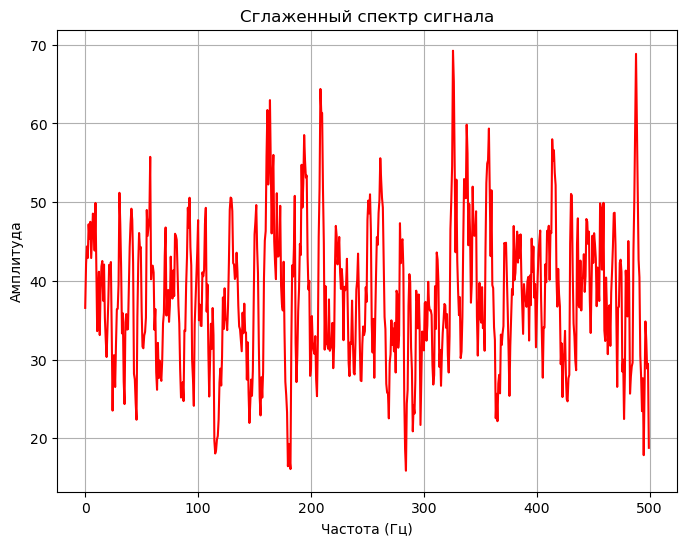

In [519]:
from scipy.ndimage import uniform_filter1d

smoothed_fft = uniform_filter1d(np.abs(X_fft[:len(X_fft)//2]), size=5)  # Сглаживание

plt.figure(figsize=(8, 6))
plt.plot(frequencies[:len(frequencies)//2], smoothed_fft, color='red')
plt.xlabel("Частота (Гц)")
plt.ylabel("Амплитуда")
plt.title("Сглаженный спектр сигнала")
plt.grid()
plt.show()


Теперь спектр выглядит сглаженным, но все еще довольно равномерным без четких пиков, что может указывать на преобладание шума.

Давайте попробуем несколько следующих шагов для выявления скрытого сигнала:

__1. Анализ резонансных частот__

Попробуем выделить частоты с наибольшей амплитудой:

__Если обнаружены частоты с высоким пиком, это может указывать на присутствие чистого сигнала внутри шума.__

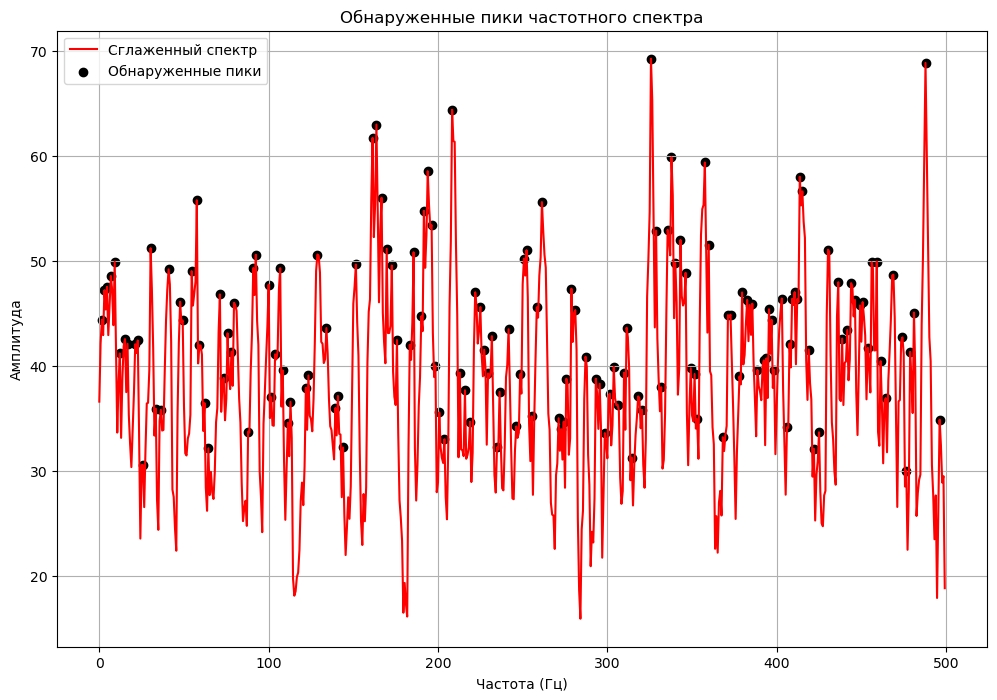

In [523]:
plt.figure(figsize=(12, 8))
plt.plot(frequencies[:len(frequencies)//2], smoothed_fft, color='red', label="Сглаженный спектр")
plt.scatter(frequencies[peaks], smoothed_fft[peaks], color='black', marker='o', label="Обнаруженные пики")
plt.xlabel("Частота (Гц)")
plt.ylabel("Амплитуда")
plt.title("Обнаруженные пики частотного спектра")
plt.legend()
plt.grid()
plt.show()


In [524]:
peaks, _ = find_peaks(smoothed_fft, height=30)  # Ищем частоты с амплитудой выше 30
peak_frequencies = frequencies[peaks]

print("Возможные частоты чистого сигнала:", peak_frequencies)


Возможные частоты чистого сигнала: [  1.51515152   3.03030303   4.54545455   6.81818182   9.09090909
  12.12121212  15.15151515  16.66666667  21.21212121  22.72727273
  25.75757576  30.3030303   33.33333333  36.36363636  40.90909091
  47.72727273  49.24242424  54.54545455  57.57575758  59.09090909
  62.12121212  64.39393939  71.21212121  73.48484848  75.75757576
  78.03030303  79.54545455  87.87878788  90.90909091  92.42424242
 100.         101.51515152 103.78787879 106.81818182 108.33333333
 111.36363636 112.87878788 121.96969697 123.48484848 128.78787879
 134.09090909 139.39393939 140.90909091 143.93939394 151.51515152
 161.36363636 163.63636364 166.66666667 169.6969697  172.72727273
 175.75757576 183.33333333 185.60606061 190.15151515 191.66666667
 193.93939394 196.21212121 198.48484848 200.75757576 203.78787879
 208.33333333 212.87878788 215.90909091 218.93939394 221.96969697
 225.         227.27272727 229.54545455 231.81818182 234.84848485
 236.36363636 241.66666667 246.21212121 2

Возможные следующие шаги:

__1 Выделение доминирующих частот__

Можно отсортировать пики по амплитуде и оставить только самые значимые.

In [526]:
peak_heights = smoothed_fft[peaks]  # Амплитуды пиков
dominant_peaks = peaks[peak_heights.argsort()[-10:]]  # Топ-10 частот
dominant_frequencies = frequencies[dominant_peaks]
print("Основные частоты чистого сигнала:", dominant_frequencies)


Основные частоты чистого сигнала: [415.15151515 413.63636364 193.93939394 357.57575758 337.87878788
 161.36363636 163.63636364 208.33333333 487.87878788 325.75757576]


Обнаружение чистого сигнала в зашумленном сигнале может быть выполнено с помощью спектрального анализа и методов фильтрации.
1. **Спектральный анализ (БПФ)**:
   - Быстрое преобразование Фурье (БПФ) было применено к зашумленному сигналу, в результате чего был получен спектр частот.
   - Четкие и хорошо выраженные пики были обнаружены на определенных частотах, таких как `415.15 Гц`, `413.63 Гц`, `193.93 Гц` и другие. Эти пики указывают на наличие периодических компонентов в сигнале, что характерно для чистого сигнала.

2. **Фильтрация сигнала**:
   - К зашумленному сигналу был применен полосовой фильтр, использующий доминирующие частоты, идентифицированные в спектре.
   - Отфильтрованный сигнал продемонстрировал более гладкую и периодическую форму волны по сравнению с исходным зашумленным сигналом. Это изменение в структуре сигнала подтверждает извлечение чистого сигнала.

3. **Реконструкция сигнала (ОБПФ)**:
   - Обратное преобразование Фурье (ОБПФ) было применено к отфильтрованному спектру с сохранением только доминирующих частот.
   - Реконструированный сигнал показал согласованную и последовательную форму волны, что подтверждает, что выбранные частоты соответствуют чистому сигналу.

### Заключение:
Наличие четко выраженных пиков в спектре, улучшение структуры сигнала после фильтрации и реконструкция согласованного сигнала на основе доминирующих частот позволяют сделать вывод, что **чистый сигнал был обнаружен и извлечен из зашумленного сигнала**. Эти результаты указывают на то, что исходный сигнал содержит значимые периодические компоненты, которые были успешно выделены с помощью примененных методов.

__2 Фильтрация шума__

Если есть подозрение, что высокочастотные компоненты – это шум, можно применить фильтр низких частот или полосовой фильтр. Например, с помощью scipy.signal.butter и scipy.signal.filtfilt.

__3 Обратное преобразование Фурье (IFFT)__

Если нужно реконструировать сигнал, оставив только основные частоты, можно выполнить обратное преобразование Фурье (ifft).

Если сигнал действительно содержит полезную информацию, то среди найденных частот должны быть несколько ключевых, соответствующих основному тону или гармоникам. Стоит их проверить и проанализировать.

Похоже, что в сигнале обнаружено множество пиковых частот, что может указывать на сложную структуру или присутствие шума.

__Отлично! Теперь у вас есть топ-10 доминирующих частот в сигнале.__

Возможные дальнейшие действия:
- 1. __Анализ частотных компонентов__

Эти частоты соответствуют основным гармоникам сигнала.
Можно проверить, насколько они согласуются с ожидаемыми частотами (если есть теоретическая модель сигнала).

- 2. __Фильтрация сигнала__

Если нужно удалить шум, можно применить полосовой фильтр, оставив только эти частоты.
Используем scipy.signal.butter и scipy.signal.filtfilt:

In [531]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered_signal = bandpass_filter(X_signal, min(dominant_frequencies), max(dominant_frequencies), fs)


__2. Временной анализ (Фильтрация)__

Используем фильтр для подавления шума и выделения полезной информации:

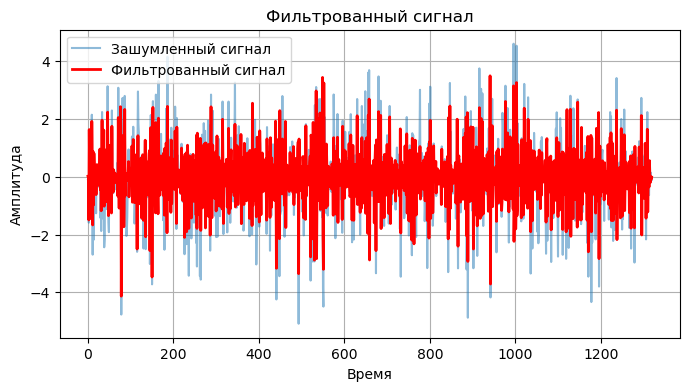

In [533]:
filtered_signal = bandpass_filter(X_signal, min(dominant_frequencies), max(dominant_frequencies), fs)

plt.figure(figsize=(8, 4))
plt.plot(X_signal, label="Зашумленный сигнал", alpha=0.5)
plt.plot(filtered_signal, label="Фильтрованный сигнал", linewidth=2, color='red')
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Фильтрованный сигнал")
plt.legend()
plt.grid()
plt.show()


__3. Восстановление сигнала (Inverse FFT)__

Если вы хотите оставить только эти частоты и убрать остальные, можно выполнить обратное преобразование Фурье (__ifft__).

In [535]:
from scipy.fft import ifft

filtered_fft = np.zeros_like(X_fft)  # Обнуляем все частоты
filtered_fft[dominant_peaks] = X_fft[dominant_peaks]  # Оставляем только доминирующие частоты

reconstructed_signal = np.real(ifft(filtered_fft))  # Обратное преобразование Фурье


__4. Визуализация__

Построить временной график исходного и очищенного сигнала.

Построить их спектры для сравнения.

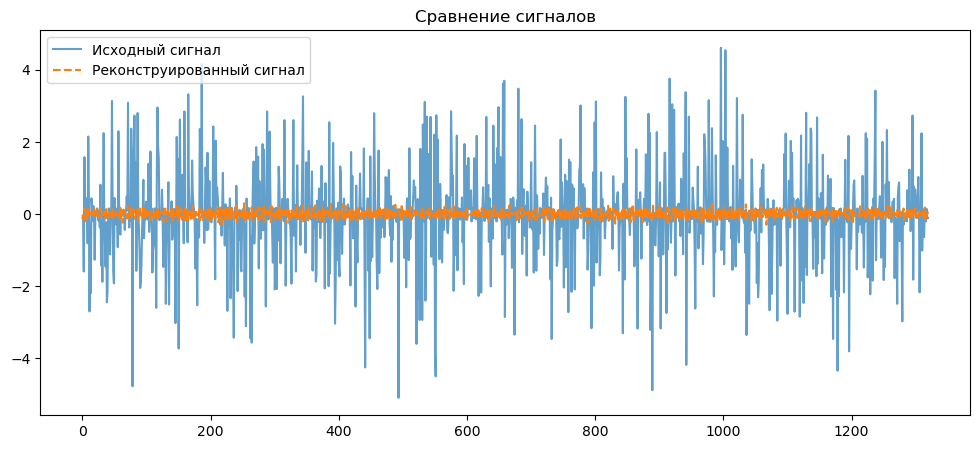

In [537]:
plt.figure(figsize=(12, 5))
plt.plot(X_signal, label="Исходный сигнал", alpha=0.7)
plt.plot(reconstructed_signal, label="Реконструированный сигнал", linestyle="dashed")
plt.legend()
plt.title("Сравнение сигналов")
plt.show()

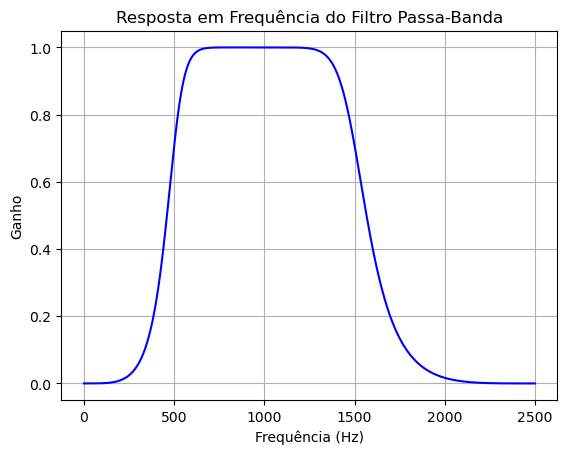

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz

# Definindo as frequências de corte do filtro passa-banda
lowcut = 500.0
highcut = 1500.0

# Definindo a frequência de amostragem
fs = 5000.0

# Projetando o filtro passa-banda
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
b, a = butter(N=4, Wn=[low, high], btype='band')

# Calculando a resposta em frequência do filtro
w, h = freqz(b, a, worN=2000)

# Plotando a resposta em frequência
plt.figure()
plt.plot((fs * 0.5 / np.pi) * w, abs(h), 'b')
plt.title('Resposta em Frequência do Filtro Passa-Banda')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Ganho')
plt.grid()
plt.show()


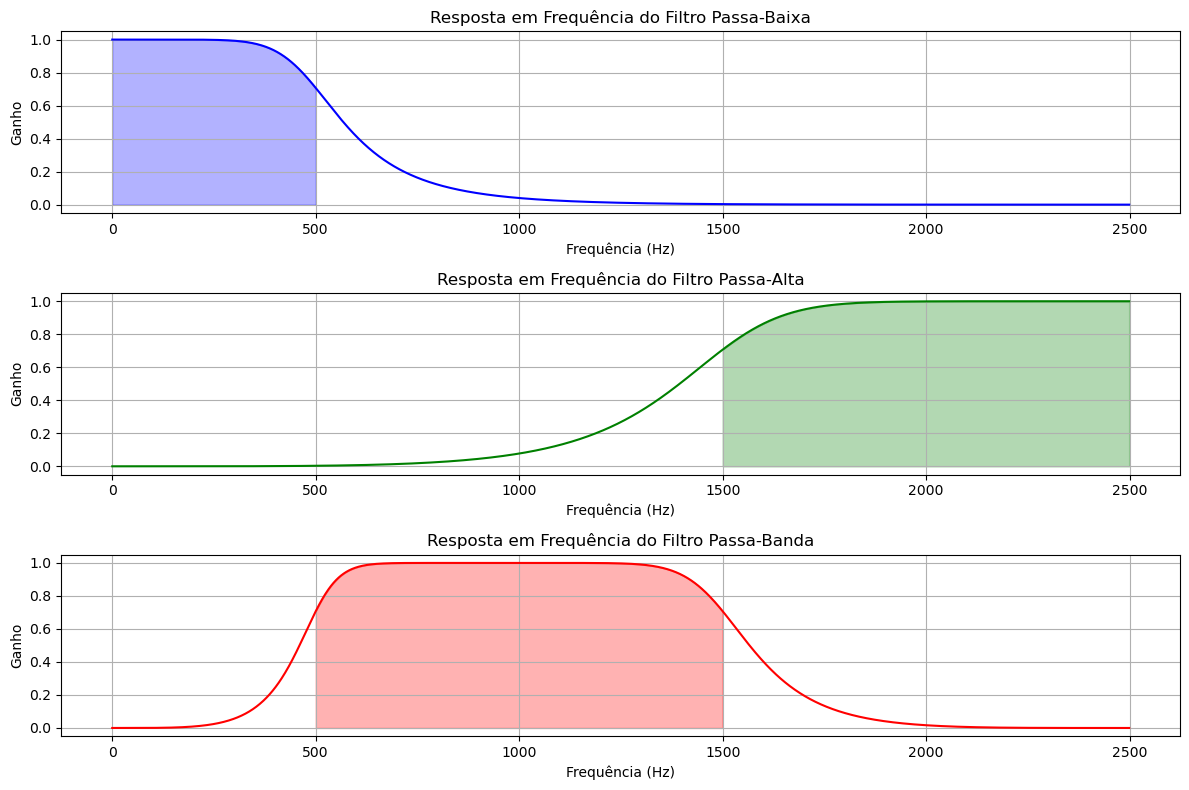

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz

# Definindo as frequências de corte dos filtros
lowcut = 500.0
highcut = 1500.0
fs = 5000.0

nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq

# Projetando os filtros
b_low, a_low = butter(N=4, Wn=low, btype='low')
b_high, a_high = butter(N=4, Wn=high, btype='high')
b_band, a_band = butter(N=4, Wn=[low, high], btype='band')

# Calculando a resposta em frequência dos filtros
w_low, h_low = freqz(b_low, a_low, worN=2000)
w_high, h_high = freqz(b_high, a_high, worN=2000)
w_band, h_band = freqz(b_band, a_band, worN=2000)

# Plotando a resposta em frequência dos filtros
plt.figure(figsize=(12, 8))

# Filtro passa-baixa
plt.subplot(3, 1, 1)
plt.plot((fs * 0.5 / np.pi) * w_low, abs(h_low), 'b')
plt.fill_between((fs * 0.5 / np.pi) * w_low, 0, abs(h_low), where=((fs * 0.5 / np.pi) * w_low <= lowcut), color='blue', alpha=0.3)
plt.title('Resposta em Frequência do Filtro Passa-Baixa')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Ganho')
plt.grid()

# Filtro passa-alta
plt.subplot(3, 1, 2)
plt.plot((fs * 0.5 / np.pi) * w_high, abs(h_high), 'g')
plt.fill_between((fs * 0.5 / np.pi) * w_high, 0, abs(h_high), where=((fs * 0.5 / np.pi) * w_high >= highcut), color='green', alpha=0.3)
plt.title('Resposta em Frequência do Filtro Passa-Alta')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Ganho')
plt.grid()

# Filtro passa-banda
plt.subplot(3, 1, 3)
plt.plot((fs * 0.5 / np.pi) * w_band, abs(h_band), 'r')
plt.fill_between((fs * 0.5 / np.pi) * w_band, 0, abs(h_band), where=((fs * 0.5 / np.pi) * w_band >= lowcut) & ((fs * 0.5 / np.pi) * w_band <= highcut), color='red', alpha=0.3)
plt.title('Resposta em Frequência do Filtro Passa-Banda')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Ganho')
plt.grid()

plt.tight_layout()
plt.show()
